In [2]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

2022-08-01 11:21:39.056396: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yang/carla-ros-bridge/catkin_ws/devel/lib:/opt/ros/melodic/lib
2022-08-01 11:21:39.056436: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [28]:
def get_path(name: str, base_dir='/home/yang/carla-driving-rl-agent/weights'):
    return os.path.join(base_dir, name, 'evaluation')

In [29]:
# constants
PATHS = {'curriculum': get_path(name='stage-s5-curriculum'),
         'standard': get_path(name='stage-s5-standard'),
         'untrained': get_path(name='stage-s5-untrained')}

COLUMNS = ['collision_rate', 'similarity', 'waypoint_distance', 
           'speed', 'total_reward', 'timesteps']

In [30]:
os.listdir(PATHS['standard'])

['stage-s5-standard-test-512-50-Town06-regular-42.json',
 'stage-s5-standard-train-512-50-Town03-no-42.json',
 'stage-s5-standard-train-512-50-Town06-dense-42.json',
 'stage-s5-standard-train-512-50-Town10-regular-42.json',
 'stage-s5-standard-test-512-50-Town01-regular-42.json',
 'stage-s5-standard-train-512-50-Town10-dense-42.json',
 'stage-s5-standard-test-512-50-Town04-no-42.json',
 'stage-s5-standard-test-512-50-Town10-no-42.json',
 'stage-s5-standard-train-512-50-Town05-dense-42.json',
 'stage-s5-standard-test-512-50-Town02-dense-42.json',
 'stage-s5-standard-train-512-50-Town01-no-42.json',
 'stage-s5-standard-train-512-50-Town07-dense-42.json',
 'stage-s5-standard-test-512-50-Town03-dense-42.json',
 'stage-s5-standard-test-512-50-Town06-dense-42.json',
 'stage-s5-standard-train-512-50-Town05-regular-42.json',
 'stage-s5-standard-train-512-50-Town02-regular-42.json',
 'stage-s5-standard-train-512-50-Town03-dense-42.json',
 'stage-s5-standard-train-512-50-Town04-dense-42.json',
 

---

In [31]:
def get_eval_keys(filename: str) -> str:
    splits = filename.split('-')[:-1]
    traffic, town, weather = splits[-1], splits[-2], splits[-5]
    
    return f'{traffic}-{town}-{weather}'

In [32]:
def get_statistics(v, digits=None) -> dict:
    stats = dict(mean=np.mean(v), std=np.std(v), median=np.median(v))
    
    if digits is None:
        return stats
    
    return {k: np.round(v, digits) for k, v in stats.items()}
    

def clip_outliers(data, col: str):
    values = data[col]
    
    if col == 'total_reward':
        return np.clip(values, a_min=-1000.0, a_max=None)
        
    elif col == 'speed':
        return np.clip(values, a_min=None, a_max=15.0)

    elif col == 'waypoint_distance':
        return np.clip(values, a_min=None, a_max=20.0)
    
    return values

def aggregate_file(path: str, round=None) -> dict:
    result = dict()
    
    with open(path, 'r') as file:
        data = json.load(file)
    
    for col in COLUMNS:
        values = clip_outliers(data, col)
        result[col] = get_statistics(values, digits=round)

    return result

In [34]:
aggregate_file(os.path.join(PATHS['standard'], 'stage-s5-standard-test-512-50-Town01-dense-42.json'))

{'collision_rate': {'mean': 0.9, 'std': 0.3, 'median': 1.0},
 'similarity': {'mean': 0.9069090356435449,
  'std': 0.24569562954948082,
  'median': 0.9768159754469672},
 'waypoint_distance': {'mean': 2.3862113463506174,
  'std': 2.7639532990229854,
  'median': 1.8827895869418794},
 'speed': {'mean': 8.28038095164753,
  'std': 2.3105667980711693,
  'median': 8.649552255416172},
 'total_reward': {'mean': 1415.4063866571803,
  'std': 1272.1665666799083,
  'median': 1612.6749740855676},
 'timesteps': {'mean': 267.56, 'std': 156.11664357140145, 'median': 268.5}}

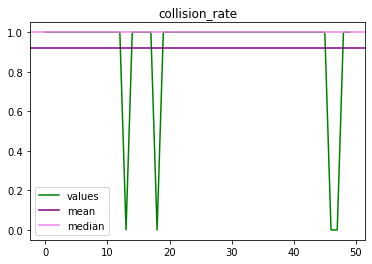

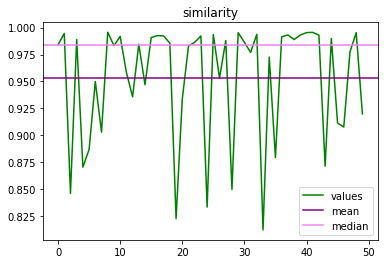

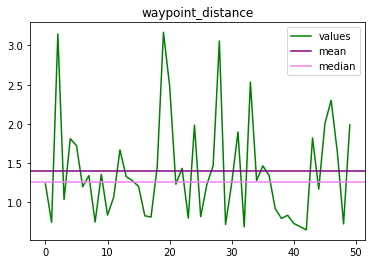

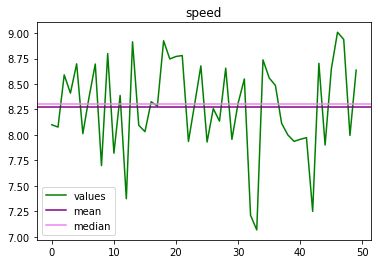

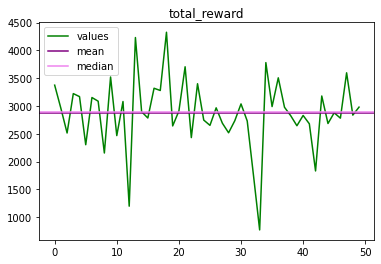

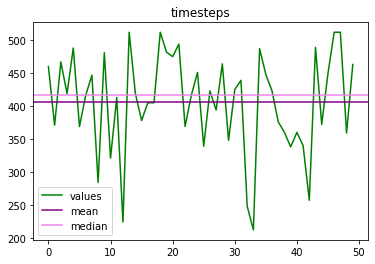

In [37]:
def plot_eval(path: str):
    with open(path, 'r') as file:
        data = json.load(file)
    
    for col in COLUMNS:
        values = data[col]
        stats = get_statistics(values)
        
        plt.plot(values, c='green', label='values')
        plt.title(col)
        plt.axhline(y=stats['mean'], c='purple', label='mean')
        plt.axhline(y=stats['median'], c='violet', label='median')
        plt.legend()
        plt.show()

# plot_eval(os.path.join(PATHS['standard'], 'stage-s5-only-test-512-50-Town03-no-42.json'))
plot_eval(os.path.join(PATHS['curriculum'], 'stage-s5-curriculum-test-512-50-Town03-no-42.json'))

In [38]:
def aggregate_evaluation(folder: str, round_digit=2) -> dict:
#     results = dict(no={}, regular={}, dense={})
    results = dict()
    
    for file in os.listdir(folder):
        key = get_eval_keys(filename=file)
        results[key] = aggregate_file(path=os.path.join(folder, file), round=round_digit)
    
    return results

In [39]:
aggregate_evaluation(folder=PATHS['curriculum'])

{'no-Town03-train': {'collision_rate': {'mean': 0.8,
   'std': 0.4,
   'median': 1.0},
  'similarity': {'mean': 0.95, 'std': 0.05, 'median': 0.98},
  'waypoint_distance': {'mean': 1.43, 'std': 0.57, 'median': 1.34},
  'speed': {'mean': 8.36, 'std': 0.47, 'median': 8.43},
  'total_reward': {'mean': 3024.37, 'std': 670.03, 'median': 3025.07},
  'timesteps': {'mean': 424.38, 'std': 73.36, 'median': 429.5}},
 'no-Town06-test': {'collision_rate': {'mean': 0.12,
   'std': 0.32,
   'median': 0.0},
  'similarity': {'mean': 0.98, 'std': 0.03, 'median': 1.0},
  'waypoint_distance': {'mean': 4.17, 'std': 3.83, 'median': 3.21},
  'speed': {'mean': 9.16, 'std': 0.39, 'median': 9.28},
  'total_reward': {'mean': 2552.45, 'std': 1810.43, 'median': 2226.63},
  'timesteps': {'mean': 488.16, 'std': 74.64, 'median': 512.0}},
 'regular-Town05-test': {'collision_rate': {'mean': 0.48,
   'std': 0.5,
   'median': 0.0},
  'similarity': {'mean': 0.9, 'std': 0.23, 'median': 0.98},
  'waypoint_distance': {'mean':

In [40]:
# aggregate all results by agent:
results = dict()

for agent, path in PATHS.items():
    results[agent] = aggregate_evaluation(folder=path)

# write as json
with open('evaluation.json', 'w') as file:
    json.dump(results, fp=file, indent=4)

In [41]:
def compare(path: str):
    with open('evaluation.json', 'r') as file:
        data = json.load(file)
    
    agents = list(data.keys())
    tasks = list(data[agents[0]].keys())
    eval_keys = data[agents[0]][tasks[0]].keys()
    
    for task in tasks:
        print(f'==== {task} ====')
        
        for k in eval_keys:
            for agent in agents:
                v = data[agent][task][k]
                print(f'[{agent: <10}] {k}: {v}')
            print(70 * '-')

In [42]:
compare('evaluation.json')

==== no-Town03-train ====
[curriculum] collision_rate: {'mean': 0.8, 'std': 0.4, 'median': 1.0}
[standard  ] collision_rate: {'mean': 0.88, 'std': 0.32, 'median': 1.0}
[untrained ] collision_rate: {'mean': 0.98, 'std': 0.14, 'median': 1.0}
----------------------------------------------------------------------
[curriculum] similarity: {'mean': 0.95, 'std': 0.05, 'median': 0.98}
[standard  ] similarity: {'mean': 0.93, 'std': 0.12, 'median': 0.98}
[untrained ] similarity: {'mean': 0.82, 'std': 0.16, 'median': 0.88}
----------------------------------------------------------------------
[curriculum] waypoint_distance: {'mean': 1.43, 'std': 0.57, 'median': 1.34}
[standard  ] waypoint_distance: {'mean': 1.62, 'std': 0.97, 'median': 1.31}
[untrained ] waypoint_distance: {'mean': 3.06, 'std': 1.79, 'median': 2.61}
----------------------------------------------------------------------
[curriculum] speed: {'mean': 8.36, 'std': 0.47, 'median': 8.43}
[standard  ] speed: {'mean': 8.37, 'std': 1.06, 

In [44]:
def performance_per_town(path: str, relative=True):
    def get_towns(tasks: list) -> list:
        towns = dict()
        
        for task in tasks:
            town = task.split('-')[1]
            towns[town] = True
        
        return list(towns.keys())
    
    def normalize(d: dict, metric: str) -> dict:
        if metric in ['collision_rate', 'waypoint_distance']:
            minimum = min(d.values())
            return {k: round(100 * v / minimum, 1) for k, v in d.items()} 
        
        # similarity, speed, total_reward, timesteps
        maximum = max(d.values())
        return {k: round(100 * v / maximum, 1) for k, v in d.items()}
    
    def average(d: dict):
        # 6 = 2 (weather set) * 3 (traffic scenarios)
        return {k: round(np.mean(v) / 6, 2) for k, v in d.items()}
    
    with open('evaluation.json', 'r') as file:
        data = json.load(file)
    
    # curriculum, standard, ...
    agents = list(data.keys())
    
    # Town01, Town02, ...
    towns = get_towns(tasks=list(data[agents[0]].keys()))
    
    # collision_rate, similarity, ...
    metrics = data[agents[0]]['dense-Town01-train'].keys()
    results = dict()
    
    for town in towns:
        result = dict()
        
        for metric in metrics:
            performance = dict()
            
            for agent in agents:
                value = 0.0
                
                for traffic in ['no', 'regular', 'dense']:
                    value += data[agent][f'{traffic}-{town}-train'][metric]['mean']
                    value += data[agent][f'{traffic}-{town}-test'][metric]['mean']
                
                performance[agent] = value
            
            if relative:
                result[metric] = normalize(performance, metric)
            else:
                result[metric] = average(performance)
        
        results[town] = result

    return results

In [45]:
results = performance_per_town('evaluation.json')
print(json.dumps(results, sort_keys=True, indent=4))

{
    "Town01": {
        "collision_rate": {
            "curriculum": 108.9,
            "standard": 100.0,
            "untrained": 125.8
        },
        "similarity": {
            "curriculum": 100.0,
            "standard": 98.9,
            "untrained": 88.1
        },
        "speed": {
            "curriculum": 90.8,
            "standard": 100.0,
            "untrained": 69.5
        },
        "timesteps": {
            "curriculum": 93.6,
            "standard": 100.0,
            "untrained": 60.4
        },
        "total_reward": {
            "curriculum": 87.4,
            "standard": 100.0,
            "untrained": 23.6
        },
        "waypoint_distance": {
            "curriculum": 100.0,
            "standard": 115.3,
            "untrained": 156.6
        }
    },
    "Town02": {
        "collision_rate": {
            "curriculum": 100.0,
            "standard": 107.2,
            "untrained": 126.4
        },
        "similarity": {
            "curriculum

In [46]:
results = performance_per_town('evaluation.json', relative=False)
print(json.dumps(results, sort_keys=True, indent=4))

{
    "Town01": {
        "collision_rate": {
            "curriculum": 0.86,
            "standard": 0.79,
            "untrained": 0.99
        },
        "similarity": {
            "curriculum": 0.95,
            "standard": 0.94,
            "untrained": 0.84
        },
        "speed": {
            "curriculum": 7.78,
            "standard": 8.58,
            "untrained": 5.96
        },
        "timesteps": {
            "curriculum": 296.1,
            "standard": 316.49,
            "untrained": 191.12
        },
        "total_reward": {
            "curriculum": 1866.66,
            "standard": 2135.32,
            "untrained": 503.91
        },
        "waypoint_distance": {
            "curriculum": 1.54,
            "standard": 1.77,
            "untrained": 2.4
        }
    },
    "Town02": {
        "collision_rate": {
            "curriculum": 0.78,
            "standard": 0.84,
            "untrained": 0.99
        },
        "similarity": {
            "curriculum"

In [47]:
def global_performance(path: str, relative=True):
    def get_towns(tasks: list) -> list:
        towns = dict()
        
        for task in tasks:
            town = task.split('-')[1]
            towns[town] = True
        
        return list(towns.keys())
    
    def normalize(d: dict, metric: str) -> dict:
        if metric in ['collision_rate', 'waypoint_distance']:
            minimum = min(d.values())
            return {k: round(100 * v / minimum, 1) for k, v in d.items()} 
        
        # similarity, speed, total_reward, timesteps
        maximum = max(d.values())
        return {k: round(100 * v / maximum, 1) for k, v in d.items()}
    
    def average(d: dict):
        # 48 = 2 (weather set) * 8 (towns) * 3 (traffic scenarios)
        return {k: round(np.mean(v) / 48, 2) for k, v in d.items()}
    
    with open('evaluation.json', 'r') as file:
        data = json.load(file)
    
    # curriculum, standard, ...
    agents = list(data.keys())
    
    # Town01, Town02, ...
    towns = get_towns(tasks=list(data[agents[0]].keys()))
    
    # collision_rate, similarity, ...
    metrics = data[agents[0]]['dense-Town01-train'].keys()
    results = dict()
    
    for metric in metrics:
        result = dict()
        performance = dict()
        
        for agent in agents:
            value = 0.0
            
            for town in towns:
                for traffic in ['no', 'regular', 'dense']:
                    value += data[agent][f'{traffic}-{town}-train'][metric]['mean']
                    value += data[agent][f'{traffic}-{town}-test'][metric]['mean']
                
            performance[agent] = value
        
        if relative:
            results[metric] = normalize(performance, metric)
        else:
            results[metric] = average(performance)

    return results

In [48]:
results = global_performance('evaluation.json')
print(json.dumps(results, sort_keys=True, indent=4))

{
    "collision_rate": {
        "curriculum": 101.7,
        "standard": 100.0,
        "untrained": 152.4
    },
    "similarity": {
        "curriculum": 100.0,
        "standard": 99.1,
        "untrained": 83.4
    },
    "speed": {
        "curriculum": 98.3,
        "standard": 100.0,
        "untrained": 70.2
    },
    "timesteps": {
        "curriculum": 100.0,
        "standard": 98.6,
        "untrained": 63.8
    },
    "total_reward": {
        "curriculum": 100.0,
        "standard": 96.0,
        "untrained": 25.8
    },
    "waypoint_distance": {
        "curriculum": 100.0,
        "standard": 103.3,
        "untrained": 117.7
    }
}


In [49]:
avg_results = global_performance('evaluation.json', relative=False)
print(json.dumps(avg_results, sort_keys=True, indent=4))

{
    "collision_rate": {
        "curriculum": 0.64,
        "standard": 0.63,
        "untrained": 0.95
    },
    "similarity": {
        "curriculum": 0.92,
        "standard": 0.91,
        "untrained": 0.77
    },
    "speed": {
        "curriculum": 8.5,
        "standard": 8.65,
        "untrained": 6.08
    },
    "timesteps": {
        "curriculum": 374.02,
        "standard": 368.82,
        "untrained": 238.76
    },
    "total_reward": {
        "curriculum": 2025.93,
        "standard": 1944.44,
        "untrained": 523.48
    },
    "waypoint_distance": {
        "curriculum": 2.98,
        "standard": 3.08,
        "untrained": 3.51
    }
}
